<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/notebooks/02_modeling_oct_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **0. Setup and Installations**

In [1]:
# --- Hugging Face Authentication (using Colab Secrets) ---
from google.colab import userdata
from huggingface_hub import login
print("Attempting Hugging Face login...")
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Could not log in. Please ensure 'HF_TOKEN' is a valid secret. Error: {e}")

Attempting Hugging Face login...
Hugging Face login successful.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.


In [3]:
# --- Install Dependencies ---
!pip install pandas
!pip install pyarrow
!pip install sentence-transformers
!pip install scikit-learn
!pip install torch
!pip install tqdm

### **1. Configuration and Helper Functions**

This section contains all hyperparameters in a `Config` class for easy management, along with the `set_seed` utility function for ensuring reproducible results. The key new parameter is `PRICE_BUCKET_SIZE`.

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import json
import time
from tqdm.notebook import tqdm

In [5]:
def set_seed(seed: int):
    """Sets the seed for all relevant RNGs to ensure reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}.")

class Config:
    # --- Data and Environment ---
    CITY: str = "nyc"
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    DRIVE_SAVE_PATH: str = "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/"

    # --- Data Pre-processing ---
    VAL_SIZE: float = 0.2
    PRICE_BUCKET_SIZE: int = 10 # Each bucket represents a $10 price range

    # --- Reproducibility ---
    SEED: int = 42

    # --- Model Training ---
    BATCH_SIZE: int = 1024
    LEARNING_RATE: float = 1e-3
    N_EPOCHS: int = 30

    # --- Early Stopping ---
    EARLY_STOPPING_PATIENCE: int = 5
    EARLY_STOPPING_MIN_DELTA: float = 1e-4 # Min change in validation loss (Cross-Entropy)

    # --- Logging ---
    LOG_EVERY_N_STEPS: int = 10

### **2. Data Loading and Splitting**

This function handles loading, outlier removal, and the 3-way stratified split. It also now includes the critical logic for creating the `price_bucket` target variable by discretizing the continuous price. The stratification is now performed on this new categorical target to ensure each price range is well-represented in both the training and validation sets.

In [6]:
def load_and_split_data(config: Config):
    """
    Loads data, creates price buckets, removes outliers, and performs a 3-way stratified split.
    """
    dataset_filename = f"{config.CITY}_final_modeling_dataset.parquet"
    dataset_path = f"./{dataset_filename}" # Assumes file in root Colab runtime

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"'{dataset_filename}' not found. Please upload it.")

    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_parquet(dataset_path)

    # --- Key Change: Create Price Buckets ---
    # This transforms the problem from regression to classification
    df['price_bucket'] = (df['target_price'] // config.PRICE_BUCKET_SIZE).astype(int)
    print(f"Created {df['price_bucket'].max() + 1} price buckets of size ${config.PRICE_BUCKET_SIZE}.")

    # Remove price outliers (top/bottom 1%)
    price_q01 = df['target_price'].quantile(0.01)
    price_q99 = df['target_price'].quantile(0.99)
    df = df[(df['target_price'] >= price_q01) & (df['target_price'] <= price_q99)].copy()
    print(f"Removed price outliers. New size: {len(df):,} records.")

    # Create a combined key for stratification, now using the price_bucket
    stratify_key = (
        df['neighbourhood_cleansed'].astype(str) + '_' +
        df['month'].astype(str) + '_' +
        df['price_bucket'].astype(str)
    )

    # Handle small strata (<2 members) to ensure valid stratified split
    strata_counts = stratify_key.value_counts()
    valid_strata = strata_counts[strata_counts >= 2].index
    df_filtered = df[stratify_key.isin(valid_strata)].copy()
    print(f"Removed small strata. New size: {len(df_filtered):,} records.")

    # Perform stratified split
    train_indices, val_indices = train_test_split(
        df_filtered.index,
        test_size=config.VAL_SIZE,
        random_state=config.SEED,
        stratify=stratify_key[df_filtered.index]
    )

    train_df = df_filtered.loc[train_indices].copy().reset_index(drop=True)
    val_df = df_filtered.loc[val_indices].copy().reset_index(drop=True)

    print(f"Split complete. Training: {len(train_df):,}, Validation: {len(val_df):,}")

    # Calculate and store the number of buckets for the model
    # Use the full dataset before splitting to capture all possible buckets
    config.N_BUCKETS = df['price_bucket'].max() + 1
    print(f"Discovered {config.N_BUCKETS} unique price buckets in the dataset.")


    print("\n--- Sample Record from Training Data ---")
    # Pretty-print the first record to verify columns, including 'price_bucket'
    print(train_df.head(1)[['target_price', 'price_bucket', 'neighbourhood_cleansed', 'month']].T)

    return train_df, val_df, config

### **3. Feature Processor**

This class encapsulates the feature engineering logic as defined in `EMBEDDINGS.md`. It learns transformations (like vocabularies and scaling parameters) from the training data via the `.fit()` method. The `.transform()` method then consistently applies these learned transformations to any dataset, preventing data leakage. This is a crucial step for creating model-ready tensors from raw dataframes.

In [7]:
class FeatureProcessor:
    def __init__(self, embedding_dim_geo: int = 32):
        self.vocabs, self.scalers = {}, {}
        self.embedding_dim_geo = embedding_dim_geo
        self.categorical_cols = [
            "neighbourhood_cleansed",
            "property_type",
            "room_type",
            "bathrooms_type",
            "bedrooms",
            "beds",
            "bathrooms_numeric"
            ]
        self.numerical_cols = [
            "accommodates",
            "review_scores_rating",
            "review_scores_cleanliness",
            "review_scores_checkin",
            "review_scores_communication",
            "review_scores_location",
            "review_scores_value",
            "host_response_rate",
            "host_acceptance_rate"
            ]
        self.log_transform_cols = ["number_of_reviews_ltm"]
        self.boolean_cols = [
            "host_is_superhost",
            "host_identity_verified",
            "instant_bookable"
            ]

    def _create_positional_encoding(self, value, max_val):
        d = self.embedding_dim_geo
        if d % 2 != 0: raise ValueError("embedding_dim_geo must be even.")
        pe = np.zeros(d)
        position = (value / max_val) * 10000
        div_term = np.exp(np.arange(0, d, 2) * -(np.log(10000.0) / d))
        pe[0::2] = np.sin(position * div_term)
        pe[1::2] = np.cos(position * div_term)
        return pe

    def fit(self, df: pd.DataFrame):
        """Learns vocabularies and scaling parameters from the training data."""
        print("Fitting FeatureProcessor...")
        for col in self.categorical_cols:
            valid_uniques = df[col].dropna().unique().tolist()
            self.vocabs[col] = {val: i for i, val in enumerate(["<UNK>"] + sorted(valid_uniques))}
        for col in self.numerical_cols + self.log_transform_cols:
            vals = np.log1p(df[col]) if col in self.log_transform_cols else df[col]
            self.scalers[col] = {'mean': vals.mean(), 'std': vals.std()}
        print("Fitting complete.")

    def transform(self, df: pd.DataFrame) -> dict:
        """Transforms a dataframe into a dictionary of numerical arrays for the model."""
        df = df.copy()

        # --- Axis 1: Location ---
        half_dim = self.embedding_dim_geo // 2
        lat_enc = np.stack(df['latitude'].apply(lambda x: self._create_positional_encoding(x, 90)[:half_dim]))
        lon_enc = np.stack(df['longitude'].apply(lambda x: self._create_positional_encoding(x, 180)[:half_dim]))
        geo_position = np.hstack([lat_enc, lon_enc])
        neighbourhood = df["neighbourhood_cleansed"].apply(lambda x: self.vocabs["neighbourhood_cleansed"].get(x, 0)).values
        location_features = {"geo_position": geo_position, "neighbourhood": neighbourhood}

        # --- Axis 2: Size & Capacity ---
        size_features = {}
        for col in ["property_type", "room_type", "bathrooms_type", "bedrooms", "beds", "bathrooms_numeric"]:
            size_features[col] = df[col].apply(lambda x: self.vocabs[col].get(x, 0) if pd.notna(x) else 0).values
        size_features["accommodates"] = ((df["accommodates"] - self.scalers["accommodates"]["mean"]) / self.scalers["accommodates"]["std"]).values

        # --- Axis 3: Quality & Reputation ---
        quality_features = {}
        for col in self.numerical_cols:
            if col != "accommodates":
                quality_features[col] = ((df[col].fillna(self.scalers[col]['mean']) - self.scalers[col]['mean']) / self.scalers[col]['std']).values
        quality_features["number_of_reviews_ltm"] = ((np.log1p(df["number_of_reviews_ltm"]) - self.scalers["number_of_reviews_ltm"]["mean"]) / self.scalers["number_of_reviews_ltm"]["std"]).values
        for col in self.boolean_cols:
            quality_features[col] = df[col].astype(float).values

        # --- Axis 5: Seasonality ---
        month_sin = np.sin(2 * np.pi * df["month"] / 12)
        month_cos = np.cos(2 * np.pi * df["month"] / 12)
        seasonality_features = {"cyclical": np.vstack([month_sin, month_cos]).T}

        return {
            "location": location_features,
            "size_capacity": size_features,
            "quality": quality_features,
            "amenities": {"text": df["amenities"].tolist()},
            "seasonality": seasonality_features,
            # --- Key Change: Return price_bucket for classification ---
            "price_bucket": df["price_bucket"].values,
            "sample_weight": df["estimated_occupancy_rate"].values
        }

### **4. AirbnbDataset Class**

The PyTorch `Dataset` class, which defines how to retrieve a single item from our processed feature dictionary.

In [8]:
class AirbnbPriceDataset(Dataset):
    def __init__(self, features: dict):
        self.features = features
        # The number of samples is determined by any top-level array in the features dict
        self.n_samples = len(features['sample_weight'])

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, index: int) -> dict:
        """Constructs a single data item for the model."""
        item = {}
        # Location
        item['loc_geo_position'] = self.features['location']['geo_position'][index]
        item['loc_neighbourhood'] = self.features['location']['neighbourhood'][index]

        # Size & Capacity
        for k, v in self.features['size_capacity'].items():
            item[f'size_{k}'] = v[index]

        # Quality & Reputation
        for k, v in self.features['quality'].items():
            item[f'qual_{k}'] = v[index]

        # Amenities & Seasonality
        item['amenities_text'] = self.features['amenities']['text'][index]
        item['season_cyclical'] = self.features['seasonality']['cyclical'][index]

        # --- Key Change: Retrieve the 'price_bucket' as the target ---
        item['target'] = self.features['price_bucket'][index]
        item['sample_weight'] = self.features['sample_weight'][index]

        return item

### **5. Dataloader Creation**

A function to create the `DataLoader` instances, including the custom collate function for batch tokenization.

In [9]:
def preprocess_and_tensorize_CPU(processor: FeatureProcessor, df: pd.DataFrame) -> dict:
    """
    Applies the feature processor and converts all data to CPU tensors with correct dtypes.
    """
    features_numpy = processor.transform(df)
    features_tensor = {}

    for key, value in features_numpy.items():
        if key == 'amenities':
            features_tensor[key] = value # Keep raw text for collate_fn
        elif isinstance(value, dict):
            # Process sub-dictionaries (e.g., location, size_capacity)
            features_tensor[key] = {}
            for sub_key, sub_val in value.items():
                # Categorical features must be 'long' for embedding layers.
                # All others (numerical, cyclical, positional) must be 'float'.
                if sub_key in processor.categorical_cols or sub_key == 'neighbourhood':
                    dtype = torch.long
                else:
                    dtype = torch.float32
                features_tensor[key][sub_key] = torch.from_numpy(sub_val).to(dtype=dtype)
        else:
            # --- Key Change: Process top-level items with specific dtypes ---
            if key == 'price_bucket':
                # Target for CrossEntropyLoss must be 'long'
                features_tensor[key] = torch.from_numpy(value).to(dtype=torch.long)
            elif key == 'sample_weight':
                features_tensor[key] = torch.from_numpy(value).to(dtype=torch.float32)

    return features_tensor

def create_dataloaders(train_features_cpu: dict, val_features_cpu: dict, config: Config):
    """Creates high-performance, reproducible PyTorch DataLoaders."""
    # This model is loaded once and used by the collate_fn in the main process
    tokenizer_model = SentenceTransformer('BAAI/bge-small-en-v1.5', device=config.DEVICE)

    def custom_collate_fn(batch: list) -> dict:
        """Tokenizes amenities text at batch creation time."""
        amenities_texts = [item.pop('amenities_text') for item in batch]
        # Default collate behavior for all other tensor items
        collated_batch = {key: torch.stack([d[key] for d in batch]) for key in batch[0].keys()}
        # Tokenize the text on-the-fly
        tokenized = tokenizer_model.tokenizer(
            amenities_texts, padding=True, truncation=True, return_tensors='pt', max_length=128
        )
        collated_batch['amenities_tokens'] = tokenized
        return collated_batch

    train_dataset = AirbnbPriceDataset(train_features_cpu)
    val_dataset = AirbnbPriceDataset(val_features_cpu)

    g = torch.Generator()
    g.manual_seed(config.SEED)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate_fn,
        generator=g,
        pin_memory=True, # Helps speed up CPU to GPU transfers
        num_workers=2    # Uses subprocesses to load data, freeing up the main process
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn,
        pin_memory=True,
        num_workers=2
    )
    print(f"DataLoaders created with pin_memory=True and num_workers=2.")
    return train_loader, val_loader

### **6. Model Architecture**

This cell defines the `MixtureOfExpertsModel`. This architecture is fundamentally different from our previous additive models and is designed to resolve the trade-off between performance and explainability.

**What's new:**
*   **The Problem Reframing:** The model treats the task as a classification problem, predicting a probability distribution over `N` discrete price buckets.
*   **Expert Sub-Networks:** We define `M=5` specialist "Expert" networks. Each expert is a small MLP that takes only its own feature axis as input (e.g., Location features) and outputs its "opinion"—a vector of `N` raw scores (logits) representing its vote for each price bucket.
*   **Gating Sub-Network:** A separate "Gating" network acts as a manager. It takes *all* features as input and outputs `M=5` weights. These weights represent how much the model should trust each of the five experts for this specific listing.
*   **Mixture of Experts:** The final probability distribution is a weighted average of the five expert opinions, using the weights produced by the gating network. This allows the model to dynamically learn which features are most important for pricing any given listing.
*   **Rich Output:** The `forward` pass returns a dictionary containing the final mixed distribution, the gating weights, and all individual expert distributions, which will be used for our powerful two-part explanation.

In [10]:
class Expert(nn.Module):
    """A simple MLP that acts as an expert for a single feature axis."""
    def __init__(self, input_dim: int, n_buckets: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, n_buckets) # Outputs raw logits for each price bucket
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class GatingNetwork(nn.Module):
    """An MLP that takes all features and outputs mixing weights for the experts."""
    def __init__(self, input_dim: int, n_experts: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_experts) # Outputs raw logits for each expert
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class MixtureOfExpertsModel(nn.Module):
    def __init__(self, processor: FeatureProcessor, config: Config):
        super().__init__()
        self.vocabs = processor.vocabs
        self.device = config.DEVICE
        self.n_buckets = config.N_BUCKETS
        self.n_experts = 5

        # --- Shared Embedding Layers ---
        self.embed_neighbourhood = nn.Embedding(len(self.vocabs['neighbourhood_cleansed']), 16)
        self.embed_property_type = nn.Embedding(len(self.vocabs['property_type']), 8)
        self.embed_room_type = nn.Embedding(len(self.vocabs['room_type']), 4)
        self.embed_bathrooms_type = nn.Embedding(len(self.vocabs['bathrooms_type']), 2)
        self.embed_bedrooms = nn.Embedding(len(self.vocabs['bedrooms']), 4)
        self.embed_beds = nn.Embedding(len(self.vocabs['beds']), 4)
        self.embed_bathrooms_numeric = nn.Embedding(len(self.vocabs['bathrooms_numeric']), 4)
        self.amenities_transformer = SentenceTransformer('BAAI/bge-small-en-v1.5', device=self.device)
        for param in self.amenities_transformer.parameters(): param.requires_grad = False

        # --- Define Input Dimensions ---
        self.input_dims = {
            "location": 48,    # 32 (geo) + 16 (hood)
            "size": 27,        # 8+4+2+4+4+4+1
            "quality": 12,       # 8 (numerical) + 1 (log) + 3 (bool)
            "amenities": 384,
            "seasonality": 2
        }
        gating_input_dim = sum(self.input_dims.values())

        # --- Expert Sub-Networks ---
        self.experts = nn.ModuleDict({
            'loc': Expert(self.input_dims['location'], self.n_buckets),
            'size': Expert(self.input_dims['size'], self.n_buckets),
            'qual': Expert(self.input_dims['quality'], self.n_buckets),
            'amenities': Expert(self.input_dims['amenities'], self.n_buckets),
            'season': Expert(self.input_dims['seasonality'], self.n_buckets)
        })

        # --- Gating Sub-Network ---
        self.gate = GatingNetwork(gating_input_dim, self.n_experts)
        self.to(self.device)

    def forward(self, batch: dict) -> dict:
        # --- 1. Prepare all feature axis inputs ---
        loc_input = torch.cat([batch['loc_geo_position'], self.embed_neighbourhood(batch['loc_neighbourhood'])], dim=1)

        size_embeds = [
            self.embed_property_type(batch['size_property_type']), self.embed_room_type(batch['size_room_type']),
            self.embed_bathrooms_type(batch['size_bathrooms_type']), self.embed_beds(batch['size_beds']),
            self.embed_bedrooms(batch['size_bedrooms']), self.embed_bathrooms_numeric(batch['size_bathrooms_numeric']),
            batch['size_accommodates'].unsqueeze(1)
        ]
        size_input = torch.cat(size_embeds, dim=1)

        qual_inputs = [ batch[f'qual_{col}'].unsqueeze(1) for col in [
                "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin",
                "review_scores_communication", "review_scores_location", "review_scores_value",
                "host_response_rate", "host_acceptance_rate", "number_of_reviews_ltm",
                "host_is_superhost", "host_identity_verified", "instant_bookable" ] ]
        qual_input = torch.cat(qual_inputs, dim=1)

        amenities_tokens = batch['amenities_tokens'].to(self.device)
        amenities_input = self.amenities_transformer(amenities_tokens)['sentence_embedding']

        season_input = batch['season_cyclical']

        # --- 2. Get Expert Opinions (as probability distributions) ---
        p_loc_logits = self.experts['loc'](loc_input)
        p_size_logits = self.experts['size'](size_input)
        p_qual_logits = self.experts['qual'](qual_input)
        p_amenities_logits = self.experts['amenities'](amenities_input)
        p_season_logits = self.experts['season'](season_input)

        # Apply softmax to get the probability distribution from each expert's opinion
        p_loc = F.softmax(p_loc_logits, dim=-1)
        p_size = F.softmax(p_size_logits, dim=-1)
        p_qual = F.softmax(p_qual_logits, dim=-1)
        p_amenities = F.softmax(p_amenities_logits, dim=-1)
        p_season = F.softmax(p_season_logits, dim=-1)

        # --- 3. Get Gating Weights ---
        gating_full_input = torch.cat([loc_input, size_input, qual_input, amenities_input, season_input], dim=1)
        gating_logits = self.gate(gating_full_input)
        # Apply softmax to get the mixing weights, which sum to 1
        v = F.softmax(gating_logits, dim=-1) # Shape: (batch_size, 5)

        # --- 4. Mix the experts ---
        # Stack expert distributions for efficient batch processing
        # Shape: (batch_size, n_experts, n_buckets)
        all_expert_probs = torch.stack([p_loc, p_size, p_qual, p_amenities, p_season], dim=1)
        # Reshape gating weights for batch matrix multiplication
        # Shape: (batch_size, 1, n_experts)
        v_reshaped = v.unsqueeze(1)
        # Perform the weighted sum: p_final = v1*p1 + v2*p2 + ...
        # Shape: (batch_size, 1, n_buckets) -> (batch_size, n_buckets)
        p_final = torch.bmm(v_reshaped, all_expert_probs).squeeze(1)

        # Clamp to avoid log(0) issues if probabilities are exactly zero
        p_final = torch.clamp(p_final, min=1e-9)

        return {
            "p_final": p_final,         # Final mixed distribution for loss calculation
            "v": v,                     # Gating weights for explainability
            "expert_probs": {           # Individual expert distributions for explainability
                "loc": p_loc,
                "size": p_size,
                "qual": p_qual,
                "amenities": p_amenities,
                "season": p_season,
            }
        }

### **7. Training Function**

This function orchestrates the training and validation loops for a given number of epochs.


In [11]:
def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    device: str
    ) -> float:
    """Runs a full evaluation pass and computes the average weighted cross-entropy loss."""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            # Move all parts of the batch to the correct device
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    batch[key] = value.to(device, non_blocking=True)
                elif isinstance(value, dict): # Handles amenities_tokens
                    for sub_key, sub_value in value.items():
                        batch[key][sub_key] = sub_value.to(device, non_blocking=True)

            targets = batch['target'] # These are the price_bucket indices
            weights = batch['sample_weight']

            outputs = model(batch)
            p_final = outputs['p_final'] # Final probability distribution

            # --- Key Change: Calculate Weighted Cross-Entropy Loss ---
            # We use NLLLoss, which is equivalent to CrossEntropyLoss if we provide log probabilities
            log_probs = torch.log(p_final)
            unweighted_loss = F.nll_loss(log_probs, targets, reduction='none')
            weighted_loss = (unweighted_loss * weights).mean()
            # ---

            total_loss += weighted_loss.item()

    return total_loss / len(data_loader)

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    config: Config
    ):
    """
    Trains the Mixture of Experts model with logging and early stopping.
    """
    print("\n--- Starting Model Training (Mixture of Experts) ---")
    start_time = time.time()
    history = []
    global_step_count = 0
    patience_counter = 0
    early_stop_flag = False

    # --- Step 0: Initial Evaluation ---
    print("Performing Step 0 evaluation...")
    avg_val_loss_0 = evaluate_model(model, val_loader, config.DEVICE)
    best_val_loss = avg_val_loss_0
    best_model_state = model.state_dict()
    print("Step 0 evaluation complete.\n")

    # --- Updated Header for the new metric ---
    header = (
        f"{'Steps':>5} | {'Epoch':>5} | {'Train W-CE Loss':>15} | "
        f"{'Val W-CE Loss':>13} | {'Patience':>8} | {'Elapsed Time'}"
    )
    print(header)
    print("-" * len(header))

    # --- Log Step 0 ---
    elapsed_time_str = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    step_stats_0 = {
        'Steps': 0, 'Epoch': 0.00,
        'Val W-CE Loss': avg_val_loss_0,
        'Patience': 0, 'Elapsed Time': elapsed_time_str
    }
    history.append(step_stats_0)
    log_line_0 = ( f"{0:>5d} | {0:>5.2f} | {'N/A':>15} | {avg_val_loss_0:>13.4f} | "
                   f"{0:>8d} | {elapsed_time_str}" )
    print(log_line_0)

    for epoch in range(config.N_EPOCHS):
        if early_stop_flag: break
        model.train()

        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.N_EPOCHS}")):
            if early_stop_flag: break

            for key, value in batch.items():
                if isinstance(value, torch.Tensor): batch[key] = value.to(config.DEVICE, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items(): batch[key][sub_key] = sub_value.to(config.DEVICE, non_blocking=True)

            targets, weights = batch['target'], batch['sample_weight']
            outputs = model(batch)
            p_final = outputs['p_final']

            log_probs = torch.log(p_final)
            unweighted_loss = F.nll_loss(log_probs, targets, reduction='none')
            loss = (unweighted_loss * weights).mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            global_step_count += 1

            if (global_step_count % config.LOG_EVERY_N_STEPS == 0):
                avg_val_loss = evaluate_model(model, val_loader, config.DEVICE)

                if avg_val_loss < best_val_loss - config.EARLY_STOPPING_MIN_DELTA:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict()
                else:
                    patience_counter += 1

                if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                    early_stop_flag = True

                elapsed_time_str = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                step_stats = {
                    'Steps': global_step_count, 'Epoch': epoch + (i + 1) / len(train_loader),
                    'Train W-CE Loss': loss.item(), 'Val W-CE Loss': avg_val_loss,
                    'Patience': patience_counter, 'Elapsed Time': elapsed_time_str
                }
                history.append(step_stats)

                log_line = ( f"{step_stats['Steps']:>5d} | {step_stats['Epoch']:>5.2f} | "
                             f"{step_stats['Train W-CE Loss']:>15.4f} | {step_stats['Val W-CE Loss']:>13.4f} | "
                             f"{step_stats['Patience']:>8d} | {step_stats['Elapsed Time']}" )
                print(log_line)

                if early_stop_flag:
                    print(f"\n--- Early Stopping Triggered at Step {global_step_count} ---")

    print("\n--- Training Complete ---")
    if best_model_state is not None:
        print(f"Loading best model state (Val W-CE Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)

    return model, pd.DataFrame(history)

### **8. Analysis and Visualization Functions**

This cell contains all the functions required to analyze the trained Mixture of Experts model. We define these first so that our main execution cell at the end can be clean and concise.

*   **`analyze_moe_model`**: This is the core analysis function. It runs inference on a given dataset, calculates the revenue-maximizing price from the model's output distribution, and returns two dataframes: a high-level summary of performance (MAPE, MAE) by price bracket, and a detailed, row-by-row dataframe with all predictions and explanation components.
*   **`plot_training_history`**: Generates a plot of the validation loss over training steps to visualize the learning process.
*   **`plot_performance_summary`**: Creates bar charts showing the model's final MAPE and MAE, segmented by different price ranges. This is our key business-facing performance metric.
*   **`plot_explanation_details`**: Visualizes the two-part explanation from the MoE model:
    1.  A bar chart of the **average gating weights**, showing which feature axes the model learned to trust the most on average.
    2.  A box plot comparing the "opinions" (peak prices) of each expert against the final recommended price, illustrating how the model balances competing signals.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_moe_model(model: nn.Module, data_loader: DataLoader, df: pd.DataFrame, config: Config):
    """
    Runs inference and produces performance summaries and detailed explanation data.
    """
    print("Analyzing model performance...")
    model.eval()

    all_p_final, all_v, all_expert_probs, all_targets = [], [], {k: [] for k in model.experts.keys()}, []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Running Inference"):
            for key, value in batch.items():
                if isinstance(value, torch.Tensor): batch[key] = value.to(config.DEVICE, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items(): batch[key][sub_key] = sub_value.to(config.DEVICE, non_blocking=True)

            outputs = model(batch)
            all_p_final.append(outputs['p_final'].cpu())
            all_v.append(outputs['v'].cpu())
            for k in all_expert_probs.keys():
                all_expert_probs[k].append(outputs['expert_probs'][k].cpu())
            all_targets.append(batch['target'].cpu())

    p_final_full = torch.cat(all_p_final)
    v_full = torch.cat(all_v)
    expert_probs_full = {k: torch.cat(all_expert_probs[k]) for k in all_expert_probs.keys()}

    # --- Derive Recommended Price from Probability Distribution ---
    # This is the key step to convert the classification output back to a price
    bucket_prices = torch.arange(config.N_BUCKETS) * config.PRICE_BUCKET_SIZE + (config.PRICE_BUCKET_SIZE / 2.0)
    expected_revenues = p_final_full * bucket_prices
    recommended_price_indices = torch.argmax(expected_revenues, dim=-1)
    recommended_prices = bucket_prices[recommended_price_indices].numpy()

    # --- Create Detailed Results DataFrame ---
    results_df = df.iloc[:len(recommended_prices)].copy()
    results_df['recommended_price'] = recommended_prices

    # Add gating weights
    expert_names = list(model.experts.keys())
    for i, name in enumerate(expert_names):
        results_df[f'v_{name}'] = v_full[:, i].numpy()

    # Add peak price from each expert's opinion
    for name, probs in expert_probs_full.items():
        peak_indices = torch.argmax(probs, dim=-1)
        results_df[f'peak_price_{name}'] = bucket_prices[peak_indices].numpy()

    # --- Calculate Performance Metrics ---
    results_df['absolute_error'] = (results_df['recommended_price'] - results_df['target_price']).abs()
    results_df['percentage_error'] = (results_df['absolute_error'] / results_df['target_price'].clip(1)).fillna(0) * 100

    price_bins = [0, 75, 150, 250, 400, results_df['target_price'].max() + 1]
    results_df['price_bin'] = pd.cut(results_df['target_price'], bins=price_bins, right=False)

    performance_summary = results_df.groupby('price_bin').agg(
        num_listings=('listing_id', 'count'),
        mae=('absolute_error', 'mean'),
        mape=('percentage_error', 'mean')
    ).reset_index()

    print("Analysis complete.")
    return performance_summary, results_df

def plot_training_history(history_df: pd.DataFrame):
    """Plots the validation loss curve."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history_df, x='Steps', y='Val W-CE Loss', marker='o', label='Validation Loss')
    plt.title('Training History: Validation Loss', fontsize=16)
    plt.xlabel('Training Steps')
    plt.ylabel('Weighted Cross-Entropy Loss')
    plt.legend()
    plt.show()

def plot_performance_summary(summary_df: pd.DataFrame):
    """Generates bar charts for MAE and MAPE by price bracket."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Model Performance on Validation Set', fontsize=20)

    # MAE Plot
    sns.barplot(ax=axes[0], data=summary_df, x='price_bin', y='mae', palette='viridis')
    axes[0].set_title('Mean Absolute Error (MAE) by Price Bracket', fontsize=14)
    axes[0].set_xlabel('True Price Range ($)')
    axes[0].set_ylabel('Mean Absolute Error ($)')
    axes[0].tick_params(axis='x', rotation=45)

    # MAPE Plot
    sns.barplot(ax=axes[1], data=summary_df, x='price_bin', y='mape', palette='plasma')
    axes[1].set_title('Mean Absolute Percentage Error (MAPE) by Price Bracket', fontsize=14)
    axes[1].set_xlabel('True Price Range ($)')
    axes[1].set_ylabel('Mean Absolute Percentage Error (%)')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_explanation_details(results_df: pd.DataFrame):
    """Visualizes the components of the MoE explanation."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle('Mixture of Experts: Explanation Analysis (Validation Set)', fontsize=20)

    # 1. Average Gating Weights (The "Who")
    gating_cols = [col for col in results_df.columns if col.startswith('v_')]
    avg_weights = results_df[gating_cols].mean().sort_values(ascending=False)
    avg_weights.index = [name.replace('v_', '') for name in avg_weights.index] # Clean names

    sns.barplot(ax=axes[0], x=avg_weights.index, y=avg_weights.values, palette='crest')
    axes[0].set_title('Average Gating Weights (Feature Importance)', fontsize=14)
    axes[0].set_ylabel('Average Weight (Contribution)')
    axes[0].set_xlabel('Expert (Feature Axis)')
    axes[0].tick_params(axis='x', rotation=45)

    # 2. Expert Opinions vs. Final Price (The "What")
    peak_cols = ['recommended_price'] + [col for col in results_df.columns if col.startswith('peak_price_')]
    plot_data = results_df[peak_cols].melt(var_name='Source', value_name='Price ($)')
    plot_data['Source'] = plot_data['Source'].str.replace('peak_price_', 'Expert: ').replace('recommended_price', 'Final Recommendation')

    sns.boxplot(ax=axes[1], data=plot_data, x='Price ($)', y='Source', palette='mako', orient='h')
    axes[1].set_title('Distribution of Expert Price Opinions', fontsize=14)
    axes[1].set_xlabel('Predicted Price ($)')
    axes[1].set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### **9. Main Execution Function**

This cell defines the `main` function, which orchestrates the entire end-to-end pipeline: data loading, feature processing, model initialization, training, artifact saving, and final analysis. The `save_artifacts` function handles saving the trained model and processor for later use in deployment.

In [13]:
def save_artifacts(artifacts: dict, config: Config):
    """Saves the essential training artifacts to a single file."""
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{config.CITY}_moe_artifacts_{timestamp}.pt"

    # Define paths for local runtime and Google Drive
    runtime_path = f"./{filename}"
    drive_path = os.path.join(config.DRIVE_SAVE_PATH, filename)

    # Ensure Google Drive directory exists
    os.makedirs(config.DRIVE_SAVE_PATH, exist_ok=True)

    print(f"\nSaving artifacts to {runtime_path} and {drive_path}...")
    try:
        torch.save(artifacts, runtime_path)
        torch.save(artifacts, drive_path)
        print("Artifacts saved successfully.")
    except Exception as e:
        print(f"Error saving artifacts: {e}")

def main(config: Config):
    """Runs the end-to-end training and analysis pipeline for the MoE model."""
    # 1. Load and split data, updating config with N_BUCKETS
    train_df, val_df, config = load_and_split_data(config)

    # 2. Process features
    processor = FeatureProcessor()
    processor.fit(train_df)
    train_features_cpu = preprocess_and_tensorize_CPU(processor, train_df)
    val_features_cpu = preprocess_and_tensorize_CPU(processor, val_df)

    # 3. Create DataLoaders
    train_loader, val_loader = create_dataloaders(train_features_cpu, val_features_cpu, config)

    # 4. Initialize model and optimizer
    model = MixtureOfExpertsModel(processor, config)
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

    # 5. Run training
    trained_model, training_history = train_model(model, train_loader, val_loader, optimizer, config)

    # 6. Collate all artifacts into a single dictionary
    artifacts = {
        "config": config,
        "processor": processor,
        "model_state_dict": trained_model.state_dict(),
        "history": training_history
    }

    # 7. Save artifacts
    save_artifacts(artifacts, config)

    # 8. Run final analysis and generate visualizations
    print("\n" + "="*50)
    print("--- Running Final Analysis on Validation Set ---")
    print("="*50)
    performance_summary, detailed_results = analyze_moe_model(trained_model, val_loader, val_df, config)

    print("\n--- Training History ---")
    plot_training_history(training_history)

    print("\n--- Model Performance Summary ---")
    print(performance_summary.to_string(index=False, float_format="%.2f"))
    plot_performance_summary(performance_summary)

    print("\n--- Model Explanation Analysis ---")
    plot_explanation_details(detailed_results)

    return artifacts, performance_summary, detailed_results

### **10. Final Execution Cell**

This is the final "run" cell. It instantiates the `Config` object, sets the master seed for reproducibility, prints a summary of the configuration, and then calls the `main` function to execute the entire pipeline.

In [14]:
# Instantiate the configuration
config = Config()
set_seed(config.SEED)

print(f"Configuration loaded:")
print(f"Device: {config.DEVICE}")
print(f"City: {config.CITY}")
print(f"Seed: {config.SEED}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Price Bucket Size: ${config.PRICE_BUCKET_SIZE}")
print("="*50)

All random seeds set to 42.
Configuration loaded:
Device: cuda
City: nyc
Seed: 42
Batch Size: 1024
Learning Rate: 0.001
Price Bucket Size: $10


Loading dataset from: ./nyc_final_modeling_dataset.parquet
Created 5006 price buckets of size $10.
Removed price outliers. New size: 81,643 records.
Removed small strata. New size: 67,707 records.
Split complete. Training: 54,165, Validation: 13,542
Discovered 97 unique price buckets in the dataset.

--- Sample Record from Training Data ---
                                  0
target_price                  198.0
price_bucket                     19
neighbourhood_cleansed  Fort Greene
month                            10
Fitting FeatureProcessor...
Fitting complete.
DataLoaders created with pin_memory=True and num_workers=2.

--- Starting Model Training (Mixture of Experts) ---
Performing Step 0 evaluation...
Step 0 evaluation complete.

Steps | Epoch | Train W-CE Loss | Val W-CE Loss | Patience | Elapsed Time
-------------------------------------------------------------------------
    0 |  0.00 |             N/A |        1.2271 |        0 | 00:00:06


Epoch 1/30:   0%|          | 0/53 [00:00<?, ?it/s]

   10 |  0.19 |          1.2054 |        1.1987 |        0 | 00:00:17
   20 |  0.38 |          1.1127 |        1.1566 |        0 | 00:00:27
   30 |  0.57 |          1.1899 |        1.1047 |        0 | 00:00:37
   40 |  0.75 |          1.1002 |        1.0435 |        0 | 00:00:47
   50 |  0.94 |          1.0309 |        0.9840 |        0 | 00:00:57


Epoch 2/30:   0%|          | 0/53 [00:00<?, ?it/s]

   60 |  1.13 |          1.0147 |        0.9416 |        0 | 00:01:08
   70 |  1.32 |          0.9666 |        0.9154 |        0 | 00:01:18
   80 |  1.51 |          0.9505 |        0.9003 |        0 | 00:01:28
   90 |  1.70 |          0.9315 |        0.8912 |        0 | 00:01:38
  100 |  1.89 |          0.9361 |        0.8843 |        0 | 00:01:48


Epoch 3/30:   0%|          | 0/53 [00:00<?, ?it/s]

  110 |  2.08 |          0.9034 |        0.8790 |        0 | 00:01:58
  120 |  2.26 |          0.9363 |        0.8737 |        0 | 00:02:08
  130 |  2.45 |          0.9442 |        0.8699 |        0 | 00:02:18
  140 |  2.64 |          0.9476 |        0.8667 |        0 | 00:02:28
  150 |  2.83 |          0.9266 |        0.8630 |        0 | 00:02:38


Epoch 4/30:   0%|          | 0/53 [00:00<?, ?it/s]

  160 |  3.02 |          0.9573 |        0.8606 |        0 | 00:02:49
  170 |  3.21 |          0.9758 |        0.8581 |        0 | 00:02:59
  180 |  3.40 |          0.9042 |        0.8554 |        0 | 00:03:09
  190 |  3.58 |          0.8817 |        0.8532 |        0 | 00:03:19
  200 |  3.77 |          0.9211 |        0.8519 |        0 | 00:03:29
  210 |  3.96 |          0.9115 |        0.8507 |        0 | 00:03:39


Epoch 5/30:   0%|          | 0/53 [00:00<?, ?it/s]

  220 |  4.15 |          0.8655 |        0.8490 |        0 | 00:03:49
  230 |  4.34 |          0.9462 |        0.8478 |        0 | 00:03:59
  240 |  4.53 |          0.8802 |        0.8469 |        0 | 00:04:09
  250 |  4.72 |          0.9436 |        0.8452 |        0 | 00:04:19
  260 |  4.91 |          0.9273 |        0.8442 |        0 | 00:04:30


Epoch 6/30:   0%|          | 0/53 [00:00<?, ?it/s]

  270 |  5.09 |          0.8417 |        0.8433 |        0 | 00:04:41
  280 |  5.28 |          0.9055 |        0.8426 |        0 | 00:04:51
  290 |  5.47 |          0.9092 |        0.8421 |        0 | 00:05:01
  300 |  5.66 |          0.9057 |        0.8412 |        0 | 00:05:11
  310 |  5.85 |          0.9362 |        0.8416 |        1 | 00:05:21


Epoch 7/30:   0%|          | 0/53 [00:00<?, ?it/s]

  320 |  6.04 |          0.9257 |        0.8408 |        0 | 00:05:32
  330 |  6.23 |          0.8379 |        0.8395 |        0 | 00:05:42
  340 |  6.42 |          0.8533 |        0.8385 |        0 | 00:05:52
  350 |  6.60 |          0.8851 |        0.8382 |        0 | 00:06:02
  360 |  6.79 |          0.9504 |        0.8382 |        1 | 00:06:12
  370 |  6.98 |          0.8831 |        0.8380 |        0 | 00:06:22


Epoch 8/30:   0%|          | 0/53 [00:00<?, ?it/s]

  380 |  7.17 |          0.9397 |        0.8372 |        0 | 00:06:34
  390 |  7.36 |          0.8462 |        0.8371 |        1 | 00:06:44
  400 |  7.55 |          0.8577 |        0.8353 |        0 | 00:06:54
  410 |  7.74 |          0.8791 |        0.8355 |        1 | 00:07:04
  420 |  7.92 |          0.8777 |        0.8348 |        0 | 00:07:14


Epoch 9/30:   0%|          | 0/53 [00:00<?, ?it/s]

  430 |  8.11 |          0.8675 |        0.8336 |        0 | 00:07:25
  440 |  8.30 |          0.8804 |        0.8328 |        0 | 00:07:35
  450 |  8.49 |          0.8722 |        0.8311 |        0 | 00:07:45
  460 |  8.68 |          0.8993 |        0.8288 |        0 | 00:07:55
  470 |  8.87 |          0.9222 |        0.8271 |        0 | 00:08:06


Epoch 10/30:   0%|          | 0/53 [00:00<?, ?it/s]

  480 |  9.06 |          0.8724 |        0.8258 |        0 | 00:08:17
  490 |  9.25 |          0.8683 |        0.8253 |        0 | 00:08:27
  500 |  9.43 |          0.9202 |        0.8224 |        0 | 00:08:38
  510 |  9.62 |          0.8914 |        0.8207 |        0 | 00:08:48
  520 |  9.81 |          0.9163 |        0.8191 |        0 | 00:08:58
  530 | 10.00 |          0.8850 |        0.8174 |        0 | 00:09:08


Epoch 11/30:   0%|          | 0/53 [00:00<?, ?it/s]

  540 | 10.19 |          0.8340 |        0.8168 |        0 | 00:09:19
  550 | 10.38 |          0.8909 |        0.8159 |        0 | 00:09:29
  560 | 10.57 |          0.8899 |        0.8141 |        0 | 00:09:38
  570 | 10.75 |          0.8857 |        0.8120 |        0 | 00:09:48
  580 | 10.94 |          0.8708 |        0.8110 |        0 | 00:09:59


Epoch 12/30:   0%|          | 0/53 [00:00<?, ?it/s]

  590 | 11.13 |          0.8592 |        0.8108 |        0 | 00:10:10
  600 | 11.32 |          0.8327 |        0.8089 |        0 | 00:10:20
  610 | 11.51 |          0.8882 |        0.8072 |        0 | 00:10:31
  620 | 11.70 |          0.8285 |        0.8059 |        0 | 00:10:41
  630 | 11.89 |          0.8244 |        0.8087 |        1 | 00:10:51


Epoch 13/30:   0%|          | 0/53 [00:00<?, ?it/s]

  640 | 12.08 |          0.8490 |        0.8070 |        2 | 00:11:02
  650 | 12.26 |          0.8319 |        0.8031 |        0 | 00:11:12
  660 | 12.45 |          0.8281 |        0.8024 |        0 | 00:11:22
  670 | 12.64 |          0.8518 |        0.8032 |        1 | 00:11:33
  680 | 12.83 |          0.8778 |        0.7983 |        0 | 00:11:43


Epoch 14/30:   0%|          | 0/53 [00:00<?, ?it/s]

  690 | 13.02 |          0.8363 |        0.7971 |        0 | 00:11:55
  700 | 13.21 |          0.8354 |        0.7948 |        0 | 00:12:06
  710 | 13.40 |          0.8126 |        0.7956 |        1 | 00:12:16
  720 | 13.58 |          0.8149 |        0.7934 |        0 | 00:12:26
  730 | 13.77 |          0.8480 |        0.7915 |        0 | 00:12:37
  740 | 13.96 |          0.8692 |        0.7921 |        1 | 00:12:47


Epoch 15/30:   0%|          | 0/53 [00:00<?, ?it/s]

  750 | 14.15 |          0.8258 |        0.7902 |        0 | 00:12:57
  760 | 14.34 |          0.8066 |        0.7896 |        0 | 00:13:07
  770 | 14.53 |          0.8254 |        0.7915 |        1 | 00:13:17
  780 | 14.72 |          0.8202 |        0.7882 |        0 | 00:13:28
  790 | 14.91 |          0.8322 |        0.7888 |        1 | 00:13:38


Epoch 16/30:   0%|          | 0/53 [00:00<?, ?it/s]

  800 | 15.09 |          0.8182 |        0.7850 |        0 | 00:13:50
  810 | 15.28 |          0.8313 |        0.7866 |        1 | 00:14:01
  820 | 15.47 |          0.8319 |        0.7901 |        2 | 00:14:11
  830 | 15.66 |          0.8587 |        0.7855 |        3 | 00:14:22
  840 | 15.85 |          0.8051 |        0.7827 |        0 | 00:14:32


Epoch 17/30:   0%|          | 0/53 [00:00<?, ?it/s]

  850 | 16.04 |          0.8548 |        0.7814 |        0 | 00:14:44
  860 | 16.23 |          0.7813 |        0.7822 |        1 | 00:14:54
  870 | 16.42 |          0.7766 |        0.7813 |        0 | 00:15:03
  880 | 16.60 |          0.7897 |        0.7801 |        0 | 00:15:13
  890 | 16.79 |          0.8183 |        0.7795 |        0 | 00:15:24
  900 | 16.98 |          0.8653 |        0.7808 |        1 | 00:15:34


Epoch 18/30:   0%|          | 0/53 [00:00<?, ?it/s]

  910 | 17.17 |          0.8258 |        0.7792 |        0 | 00:15:46
  920 | 17.36 |          0.8795 |        0.7787 |        0 | 00:15:57
  930 | 17.55 |          0.8124 |        0.7773 |        0 | 00:16:07
  940 | 17.74 |          0.7731 |        0.7767 |        0 | 00:16:18
  950 | 17.92 |          0.8271 |        0.7745 |        0 | 00:16:29


Epoch 19/30:   0%|          | 0/53 [00:00<?, ?it/s]

  960 | 18.11 |          0.8732 |        0.7739 |        0 | 00:16:40
  970 | 18.30 |          0.8272 |        0.7737 |        0 | 00:16:51
  980 | 18.49 |          0.7637 |        0.7746 |        1 | 00:17:00
  990 | 18.68 |          0.8228 |        0.7739 |        2 | 00:17:11
 1000 | 18.87 |          0.7880 |        0.7730 |        0 | 00:17:22


Epoch 20/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1010 | 19.06 |          0.8278 |        0.7722 |        0 | 00:17:33
 1020 | 19.25 |          0.8378 |        0.7711 |        0 | 00:17:43
 1030 | 19.43 |          0.8076 |        0.7727 |        1 | 00:17:54
 1040 | 19.62 |          0.8030 |        0.7712 |        2 | 00:18:04
 1050 | 19.81 |          0.7836 |        0.7704 |        0 | 00:18:15
 1060 | 20.00 |          0.8295 |        0.7690 |        0 | 00:18:25


Epoch 21/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1070 | 20.19 |          0.7750 |        0.7707 |        1 | 00:18:38
 1080 | 20.38 |          0.8334 |        0.7682 |        0 | 00:18:48
 1090 | 20.57 |          0.8486 |        0.7692 |        1 | 00:18:59
 1100 | 20.75 |          0.7817 |        0.7729 |        2 | 00:19:09
 1110 | 20.94 |          0.7531 |        0.7702 |        3 | 00:19:20


Epoch 22/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1120 | 21.13 |          0.8066 |        0.7685 |        4 | 00:19:31
 1130 | 21.32 |          0.8385 |        0.7674 |        0 | 00:19:42
 1140 | 21.51 |          0.7700 |        0.7664 |        0 | 00:19:52
 1150 | 21.70 |          0.8369 |        0.7657 |        0 | 00:20:03
 1160 | 21.89 |          0.7934 |        0.7667 |        1 | 00:20:14


Epoch 23/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1170 | 22.08 |          0.7711 |        0.7680 |        2 | 00:20:25
 1180 | 22.26 |          0.7927 |        0.7659 |        3 | 00:20:36
 1190 | 22.45 |          0.8048 |        0.7670 |        4 | 00:20:46
 1200 | 22.64 |          0.8204 |        0.7656 |        0 | 00:20:57
 1210 | 22.83 |          0.7777 |        0.7650 |        0 | 00:21:07


Epoch 24/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1220 | 23.02 |          0.7541 |        0.7654 |        1 | 00:21:19
 1230 | 23.21 |          0.8038 |        0.7631 |        0 | 00:21:29
 1240 | 23.40 |          0.7769 |        0.7635 |        1 | 00:21:40
 1250 | 23.58 |          0.7662 |        0.7643 |        2 | 00:21:51
 1260 | 23.77 |          0.8599 |        0.7642 |        3 | 00:22:01
 1270 | 23.96 |          0.8260 |        0.7638 |        4 | 00:22:12


Epoch 25/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1280 | 24.15 |          0.7703 |        0.7628 |        0 | 00:22:23
 1290 | 24.34 |          0.7739 |        0.7631 |        1 | 00:22:33
 1300 | 24.53 |          0.8169 |        0.7628 |        2 | 00:22:44
 1310 | 24.72 |          0.7797 |        0.7623 |        0 | 00:22:54
 1320 | 24.91 |          0.7388 |        0.7610 |        0 | 00:23:05


Epoch 26/30:   0%|          | 0/53 [00:00<?, ?it/s]

 1330 | 25.09 |          0.7710 |        0.7624 |        1 | 00:23:16
 1340 | 25.28 |          0.8120 |        0.7633 |        2 | 00:23:27
 1350 | 25.47 |          0.8099 |        0.7614 |        3 | 00:23:37
 1360 | 25.66 |          0.8027 |        0.7610 |        4 | 00:23:47
 1370 | 25.85 |          0.7722 |        0.7619 |        5 | 00:23:58

--- Early Stopping Triggered at Step 1370 ---

--- Training Complete ---
Loading best model state (Val W-CE Loss: 0.7610)

Saving artifacts to ./nyc_moe_artifacts_20251010_142901.pt and /content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/nyc_moe_artifacts_20251010_142901.pt...
Artifacts saved successfully.

--- Running Final Analysis on Validation Set ---
Analyzing model performance...


Running Inference:   0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipython-input-3210329055.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_summary = results_df.groupby('price_bin').agg(


Analysis complete.

--- Training History ---


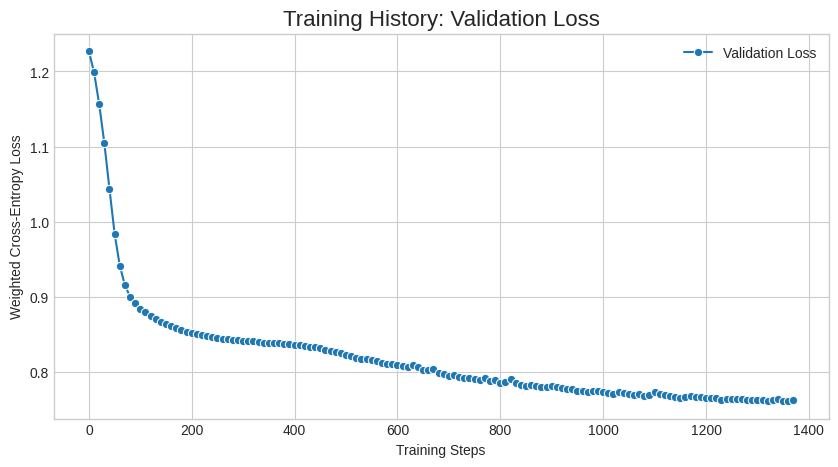


--- Model Performance Summary ---
     price_bin  num_listings    mae  mape
   [0.0, 75.0)          2218  46.39 87.26
 [75.0, 150.0)          5587  31.45 30.19
[150.0, 250.0)          3926  41.81 22.17
[250.0, 400.0)          1452  80.14 26.78
[400.0, 946.0)           359 169.73 32.66


/tmp/ipython-input-3210329055.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=summary_df, x='price_bin', y='mae', palette='viridis')
/tmp/ipython-input-3210329055.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=summary_df, x='price_bin', y='mape', palette='plasma')


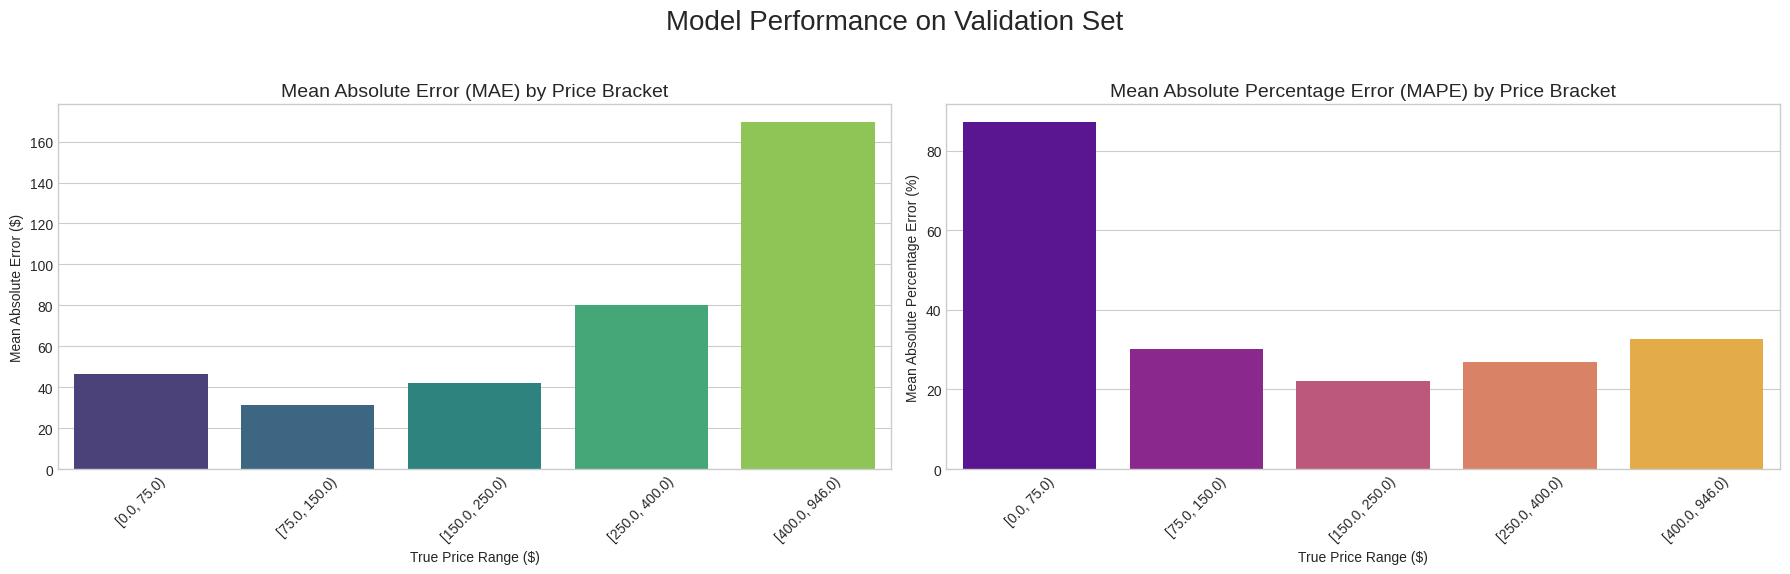


--- Model Explanation Analysis ---


/tmp/ipython-input-3210329055.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=avg_weights.index, y=avg_weights.values, palette='crest')
/tmp/ipython-input-3210329055.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=plot_data, x='Price ($)', y='Source', palette='mako', orient='h')


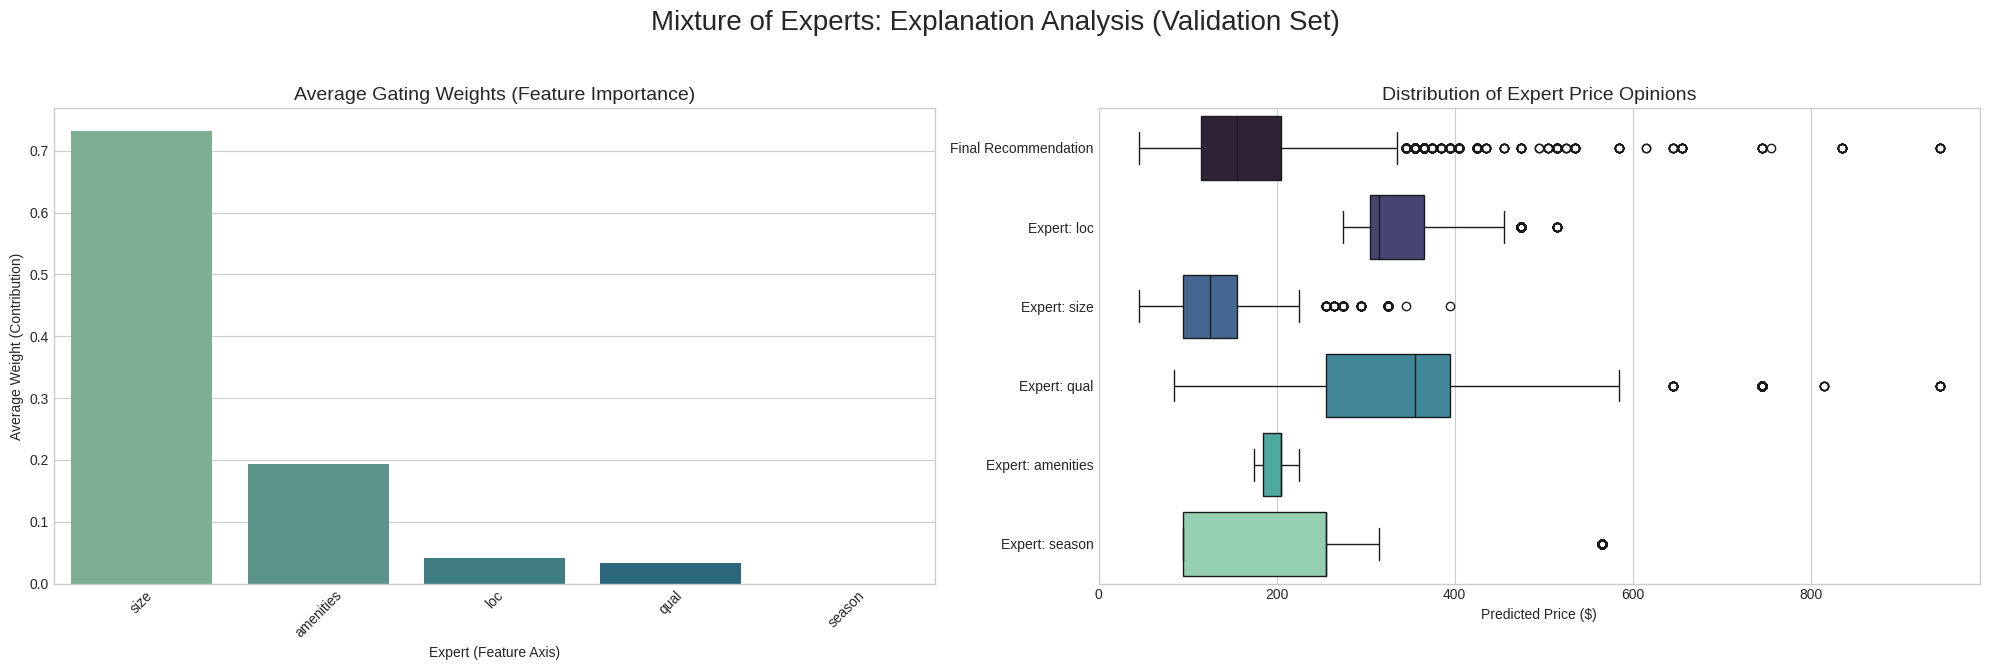

In [16]:
# Run the end-to-end training and analysis pipeline
moe_artifacts, summary, details = main(config)